# Setup

## Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from os import chdir, mkdir, getcwd, listdir
from os.path import join
import requests
from zipfile import ZipFile
import matplotlib.pyplot as plt

In [2]:
HOME = getcwd()

## Download dataset

### FAR Part 121

In [18]:
URL = 'https://github.com/fabio-a-oliveira/ds-sandbox/blob/master/FAR/ECFR-title14_labelled.xlsx?raw=true'

if 'dataset' not in listdir():
    mkdir('dataset')

r = requests.get(URL)
chdir('dataset')
with open('ECFR-title14_labelled.xlsx', 'wb') as file:
    file.write(r.content)
chdir(HOME)

df_FAA = pd.read_excel(join(HOME, 'dataset', 'ECFR-title14_labelled.xlsx'))
df_FAA = df_FAA[['title', 'requirement', 'label', 'tag']]
df_FAA

,title,requirement,label,tag
0,§ 121.1(a),§ 121.1 Applicability.This part prescribes r...,0,title only
1,§ 121.1(b),§ 121.1 Applicability.This part prescribes r...,0,title only
2,§ 121.1(c),§ 121.1 Applicability.This part prescribes r...,0,title only
3,§ 121.1(d)(1),§ 121.1 Applicability.This part prescribes r...,0,title only
4,§ 121.1(d)(2),§ 121.1 Applicability.This part prescribes r...,0,title only
...,...,...,...,...
2354,§ 121.1500(b)(3),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator
2355,§ 121.1500(b)(4),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator
2356,§ 121.1500(b)(5),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator
2357,§ 121.1500(c),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator


In [19]:
df_FAA.groupby('tag').agg({'tag':'count'})

,tag
tag,
aircraft,769
operator,1376
title only,214


### RBAC 121

In [20]:
URL = 'https://github.com/fabio-a-oliveira/ds-sandbox/blob/master/RBAC/RBAC121_labelled.xlsx?raw=true'

if 'dataset' not in listdir():
    mkdir('dataset')

r = requests.get(URL)
chdir('dataset')
with open('RBAC121_labelled.xlsx', 'wb') as file:
    file.write(r.content)
chdir(HOME)

df_ANAC = pd.read_excel(join(HOME, 'dataset', 'RBAC121_labelled.xlsx'))
df_ANAC = df_ANAC[['title', 'requirement', 'label', 'tag']]
df_ANAC


,title,requirement,label,tag
0,121.1000,"Applicability according to RBAC No. 119, which...",0,title only
1,121.2000,[Reserved] (Wording given by Resolution No. 52...,0,title only
2,121.3000,[Reserved],0,title only
3,121.4000,Applicability of the rules for unauthorized op...,0,title only
4,121.7000,Definitions The following definitions apply to...,0,title only
...,...,...,...,...
355,121.1223,[Reserved],0,title only
356,121.1225,Component “Operational security policy and obj...,2,operator
357,121.1227,“Operational security risk management” compone...,2,operator
358,121.1229,Component “guarantee of operational safety” in...,2,operator


In [21]:
df_ANAC.groupby('tag').agg({'tag':'count'})

,tag
tag,
aircraft,100
operator,207
title only,53


## Create and fit tokenizer

TO-DO: implement some text cleanup

In [34]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df_FAA.requirement.to_list())
tokenizer.fit_on_texts(df_ANAC.requirement.to_list())

dict_size = len(tokenizer.word_index)

print('Dictionary size: {}'.format(dict_size))
print('Word examples: ', end='')
print(list(tokenizer.word_index)[:100])

Dictionary size: 5896
Word examples: ['<OOV>', 'the', 'of', 'and', 'a', 'in', 'to', 'or', 'for', '121', 'this', 'flight', 'that', '§', 'is', 'by', 'an', 'airplane', 'must', 'be', 'certificate', 'section', 'with', 'as', 'may', 'each', 'holder', 'training', 'paragraph', 'at', 'required', 'b', 'operations', 'on', 'requirements', 'no', 'following', 'person', '1', 'any', 'under', 'part', 'are', 'unless', 'approved', 'not', 'data', 'c', 'it', 'aircraft', 'airplanes', 'equipment', 'pilot', 'if', '2', 'type', 'from', 'engine', 'after', 'passenger', 'provided', 'except', 'program', 'emergency', 'than', 'system', 'maintenance', 'more', 'all', 'one', 'which', 'use', 'd', 'information', 'time', 'has', 'operate', 'other', 'operating', 'category', 'least', 'command', 'specified', 'recorders', 'limitations', 'operation', 'airport', 'applicable', 'powered', '3', 'route', 'transport', 'shall', 'used', 'i', 'e', 'procedures', '000', 'have', 'include']


## Download GloVe

In [6]:
URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
chdir(HOME)

if 'GloVe' not in listdir():
    mkdir('GloVe')

if 'glove.6B.zip' not in listdir(join(HOME, 'GloVe')):
    chdir('GloVe')
    r = requests.get(URL)
    with open('glove.6B.zip', 'wb') as file:
        file.write(r.content)
    chdir(HOME)

zipfile = ZipFile(join(HOME, 'GloVe', 'glove.6B.zip'))
zipfile.extractall(join(HOME, 'GloVe'))

## Create embedding matrix

In [32]:
chdir(HOME)

keys, vectors = [], []

with open(join(HOME, 'GloVe', 'glove.6B.300d.txt'), encoding='utf-8') as file:
    for line in file:
        key, vector = line.split(' ', maxsplit=1)
        vector = np.array(vector.split(' ')).astype('float')
        keys.append(key)
        vectors.append(vector)

embedding_dict = dict(zip(keys, vectors))

In [35]:
embedding_dim = 300
embedding_matrix = np.zeros((dict_size+1, embedding_dim))

print('Words without available embedding:')
for pos, key in enumerate(tokenizer.word_index.keys()):
    if key in embedding_dict.keys():
        embedding_matrix[pos,:] = embedding_dict[key]
    else:
        print(key, end=' | ')

Words without available embedding:
<OOV> | § | holder's | aqp | §§ | nontransport | “when | installed” | flightcrew | nº | operator's | ewis | airplane's | turbopropeller | °c | manufacturer's | utlitize | fstd | nonturbine | inspac | sgso | 344a | redispatch | “no | pilot's | reseating | “conditions | icing” | vso2 | “e” | smoking” | microlamberts | crewmember's | pdsc | observer's | person's | “d” | nonpressurized | 422b | clearway | “b” | wv050 | rffs | “a” | passenger's | govinfo | 422a | “c” | dfdr | h25 | rbha | “civil | ​​the | sr422b | belt” | dfdau | fdau | 119a | pretakeoff | series6048 | washbasins | mdso | adr's | child's | “fasten | sd3 | c124a | lrns | c151 | 119b | 04a | c123a | mechanic's | airsep | sequal | aircraft's | comat | 96t | fimm | anac's | nadso | sr422 | sr422a | “seat | “this | “flight | lrcs | ifsd | 380a | engineer's | dispatcher's | fstds | individual's | inogen | lifechoice | 41104 | applicant's | notice” | “training | provider” | provider's | flugtechn

## Prepare dataset object

In [36]:
y = np.array(df_FAA.label)
x = df_FAA.requirement.map(lambda x: x.split('  ')[1])
x = np.array(x)
x = tokenizer.texts_to_sequences(x)

y_valid = np.array(df_ANAC.label)
x_valid = df_ANAC.requirement
x_valid = np.array(x_valid)
x_valid = tokenizer.texts_to_sequences(x_valid)

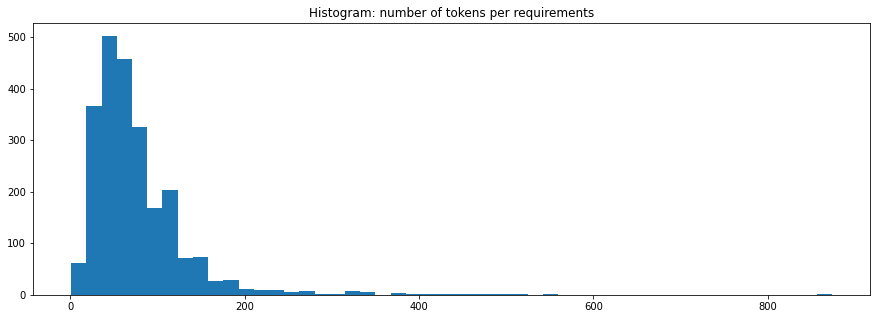

In [37]:
plt.figure(figsize = (15,5))
plt.hist(np.array([len(seq) for seq in x]), 50)
plt.title('Histogram: number of tokens per requirements')
plt.show()

In [38]:
sequence_length = 200

x = tf.keras.preprocessing.sequence.pad_sequences(x,maxlen=sequence_length, truncating='pre', padding='pre')
x = np.array(x)

x_valid = tf.keras.preprocessing.sequence.pad_sequences(x_valid,maxlen=sequence_length, truncating='pre', padding='pre')
x_valid = np.array(x_valid)

In [39]:
x = tf.data.Dataset.from_tensor_slices(x)
#x = tf.data.Dataset.from_tensor_slices(np.zeros((y.shape[0], sequence_length))) # uncomment to test with null input
y = tf.data.Dataset.from_tensor_slices(y)
dataset = tf.data.Dataset.zip((x,y)).shuffle(buffer_size = 200, seed=20210413)

x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
valid = tf.data.Dataset.zip((x_valid, y_valid))

# Build model

In [258]:
# hyperparameters
h = {'epochs':100,
     'learning_rate':.001,
     'batch_size':256,
     'recurrent_units':64,
     'dense_units':64,
     'dropout':.50,
     'recurrent_dropout':0,
     'reduce_lr_factor':.2,
     'reduce_lr_patience':100,
     'early_stopping_patience':20}

verbose = 2

In [259]:
model = tf.keras.models.Sequential(name = '2_layer_Bidirectional_GRU_2_Dense')

# add embedding layer
model.add(tf.keras.layers.Embedding(input_dim = dict_size + 1,
                                    output_dim = embedding_dim,
                                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                                    input_shape = [sequence_length],
                                    trainable = False,
                                    name = "GloVe_6B_300D"))

# add recurrent layer
GRU_layer = tf.keras.layers.GRU(h['recurrent_units'], 
                                dropout = h['dropout'], 
                                recurrent_dropout = h['recurrent_dropout'],
                                return_sequences = True, 
                                name = "GRU_1")
model.add(tf.keras.layers.Bidirectional(GRU_layer, name="Bidirectional_GRU_1"))
#model.add(tf.keras.layers.GRU(recurrent_units, return_sequences = False, name = "GRU"))

# add 2nd recurrent layer
GRU_layer = tf.keras.layers.GRU(h['recurrent_units'], 
                                dropout = h['dropout'], 
                                recurrent_dropout = h['recurrent_dropout'],
                                return_sequences = False, 
                                name = "GRU_2")
model.add(tf.keras.layers.Bidirectional(GRU_layer, name="Bidirectional_GRU_2"))

# add dense layer
model.add(tf.keras.layers.Dense(h['dense_units'], 'relu', name = 'Dense'))

# add dense output layer
model.add(tf.keras.layers.Dense(3, 'softmax', name = 'Softmax'))

# create callbacks
cb_plateau = tf.keras.callbacks.ReduceLROnPlateau(factor = h['reduce_lr_factor'], 
                                                  patience = h['reduce_lr_patience'],
                                                  min_lr = h['learning_rate'] / 100,
                                                  verbose = 1)
cb_stopping = tf.keras.callbacks.EarlyStopping(patience = h['early_stopping_patience'],
                                               restore_best_weights = True,
                                               monitor = 'val_sparse_categorical_accuracy',
                                               verbose = 1)

# compile model
model.compile(optimizer = tf.keras.optimizers.Nadam(h['learning_rate']),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])
model.summary()

Model: "2_layer_Bidirectional_GRU_2_Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GloVe_6B_300D (Embedding)    (None, 200, 300)          1769100   
_________________________________________________________________
Bidirectional_GRU_1 (Bidirec (None, 200, 128)          140544    
_________________________________________________________________
Bidirectional_GRU_2 (Bidirec (None, 128)               74496     
_________________________________________________________________
Dense (Dense)                (None, 64)                8256      
_________________________________________________________________
Softmax (Dense)              (None, 3)                 195       
Total params: 1,992,591
Trainable params: 223,491
Non-trainable params: 1,769,100
_________________________________________________________________


In [260]:
history = model.fit(dataset.batch(h['batch_size']),
                    epochs = h['epochs'],
                    verbose = verbose,
                    validation_data = valid.batch(1),
                    callbacks = [cb_plateau, cb_stopping])

Epoch 1/100
10/10 - 17s - loss: 0.9860 - sparse_categorical_accuracy: 0.5176 - val_loss: 0.9922 - val_sparse_categorical_accuracy: 0.5750
Epoch 2/100
10/10 - 10s - loss: 0.9213 - sparse_categorical_accuracy: 0.5880 - val_loss: 1.0385 - val_sparse_categorical_accuracy: 0.5750
Epoch 3/100
10/10 - 9s - loss: 0.9394 - sparse_categorical_accuracy: 0.5867 - val_loss: 0.9840 - val_sparse_categorical_accuracy: 0.5722
Epoch 4/100
10/10 - 10s - loss: 0.9122 - sparse_categorical_accuracy: 0.5901 - val_loss: 0.9844 - val_sparse_categorical_accuracy: 0.5694
Epoch 5/100
10/10 - 9s - loss: 0.9068 - sparse_categorical_accuracy: 0.5892 - val_loss: 0.9958 - val_sparse_categorical_accuracy: 0.5667
Epoch 6/100
10/10 - 9s - loss: 0.9010 - sparse_categorical_accuracy: 0.5943 - val_loss: 0.9847 - val_sparse_categorical_accuracy: 0.5639
Epoch 7/100
10/10 - 10s - loss: 0.8928 - sparse_categorical_accuracy: 0.5977 - val_loss: 0.9735 - val_sparse_categorical_accuracy: 0.5639
Epoch 8/100
10/10 - 9s - loss: 0.8807

In [261]:
loss, accuracy = model.evaluate(dataset.batch(128), verbose=0)
loss = np.round(loss, 6)
accuracy = np.round(accuracy, 3)
certainty = np.round(np.exp(-loss), 3)

val_loss, val_accuracy = model.evaluate(valid.batch(1), verbose=0)
val_loss = np.round(val_loss, 6)
val_accuracy = np.round(val_accuracy, 3)
val_certainty = np.round(np.exp(-val_loss), 3)

print("Model performance:")
print("Loss (train | valid): {} | {}".format(loss, val_loss))
print("Accuracy (train | valid): {} | {}".format(accuracy, val_accuracy))

Model performance:
Loss (train | valid): 0.132076 | 0.947427
Accuracy (train | valid): 0.95 | 0.778


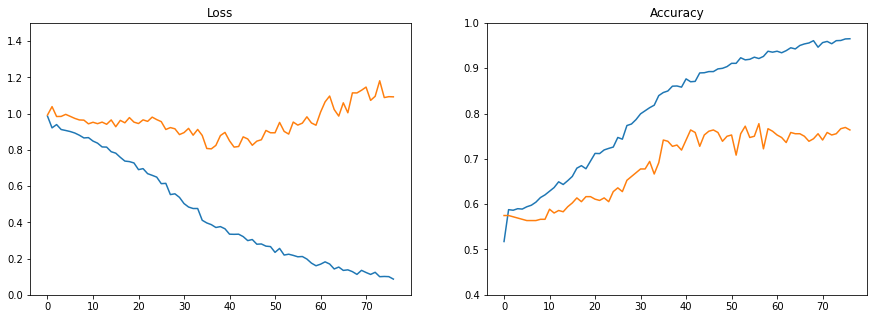

In [262]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0,1.5))

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylim((.4,1))

plt.show()

In [155]:
a = model.evaluate(valid.batch(1))

360/360 [==============================] - 5s 14ms/step - loss: 0.8464 - sparse_categorical_accuracy: 0.6778


In [156]:
a

[0.846351683139801, 0.6777777671813965]

In [ ]:
model.evaluate(verbose=0)

# Trash